In [102]:
%matplotlib inline
from matplotlib import style
plt.style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [103]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [104]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [105]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")
Base = automap_base()
engine

Engine(sqlite:///hawaii.sqlite)

In [106]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [107]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)


In [108]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [109]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [110]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [111]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [112]:
# Find the most recent date in the data set.
most_recent_dt = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_dt


('2017-08-23')

<Figure size 432x288 with 0 Axes>

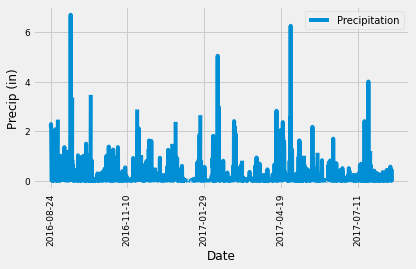

In [157]:
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.datetime(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_rows = [{"Date": result[0], "Precipitation": result[1]} for result in results]
prcp_df = pd.DataFrame(prcp_rows).set_index("Date")

# Sort the dataframe by date
prcp_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure()
prcp_df.plot(legend=True, fontsize=9)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Precip (in)', fontsize=12)
plt.xticks(rotation=90)
plt.legend(loc='best', bbox_to_anchor=(.71,1), fontsize=10)
plt.tight_layout()
plt.show()

In [159]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()